In [1]:
import stlearn as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import scanpy as sc

In [3]:
st_data = sc.read_h5ad('liver/inputQuery/spatial_liver.h5ad')
#sc_data = sc.read_h5ad('inputRef/Original_counts.h5ad') #input_ref.h5ad
#sc_data.obs['cell_type']=pd.Categorical(sc_data.obs['cluster'])
st_data.obs['cell_type']=pd.Categorical(st_data.obs['nico_ct'])

In [4]:
set(st_data.obs['nico_ct'])

{'B cells',
 'Basophils',
 'Central Vein EC',
 'Cholangiocytes',
 'Fibroblast',
 'Hep_C',
 'Hep_MC',
 'Hep_P1',
 'Hep_P2',
 'HsPCs',
 'ILC1s',
 'KCs',
 'LSECs',
 'Lymphatic EC',
 'Macro',
 'Mig. cDCs',
 'Monocytes',
 'NK cells',
 'NM',
 'Neutrophils',
 'Portain Vein EC',
 'Stellate cells',
 'T cells',
 'cDC1s',
 'cDC2s',
 'pDCs'}

In [5]:
print('1',st_data)
index=[]
for i in range(len(st_data.obs_names)):
    flag=1
    if st_data.obs['nico_ct'][i]=='NM':
        flag=0
    if st_data.obs['nico_ct'][i]=='Hep_MC':
        flag=0
    if st_data.obs['nico_ct'][i]=='Hep_P1':
        flag=0
    if st_data.obs['nico_ct'][i]=='Hep_P1':
        flag=0
    if st_data.obs['nico_ct'][i]=='Hep_C':
        flag=1    
    if flag==1:
        index.append(i)

adata=st_data[index].copy()
print('2',adata)


1 AnnData object with n_obs × n_vars = 391678 × 342
    obs: 'n_counts', 'cluster_id', 'nico_ct', 'x', 'y', 'cell_type'
    obsm: 'spatial'
2 AnnData object with n_obs × n_vars = 256565 × 342
    obs: 'n_counts', 'cluster_id', 'nico_ct', 'x', 'y', 'cell_type'
    obsm: 'spatial'


In [6]:
library_id="Xenium_FFPE_Human_Breast_Cancer_Rep1"
adata.uns["spatial"]={library_id:{}}
adata.uns['spatial'][library_id]['scalefactors']={'tissue_hires_scalef': 1, 'spot_diameter_fullres': 50}
adata.uns['spatial'][library_id]['use_quality']='hires'
adata.uns['spatial'][library_id]['images']={'hires':None}

adata.obs['imagerow']=adata.obsm['spatial'][:,1]
adata.obs['imagecol']=adata.obsm['spatial'][:,0]

In [7]:
adata.X

array([[  6.,   4.,   3., ...,   0.,   0.,   0.],
       [  0.,   1.,   0., ...,   0.,   0.,   0.],
       [  4.,   1.,   4., ...,   0.,   0.,   0.],
       ...,
       [  2.,   4.,  28., ...,   0.,   0.,   0.],
       [ 26.,  17., 299., ...,   0.,   0.,   0.],
       [  2.,   2.,  16., ...,   0.,   0.,   0.]], dtype=float32)

In [8]:
# Basic normalisation #
st.pp.filter_genes(adata, min_cells=3)
st.pp.normalize_total(adata) # NOTE: no log1p

Normalization step is finished in adata.X


In [9]:
# Loading the LR databases available within stlearn (from NATMI)
lrs = st.tl.cci.load_lrs(['connectomeDB2020_lit'], species='mouse')
print(len(lrs))

# Running the analysis #
st.tl.cci.run(adata, lrs,
                  min_spots = 20, #Filter out any LR pairs with no scores for less than min_spots
                  distance=None, # None defaults to spot+immediate neighbours; distance=0 for within-spot mode
                  n_pairs=1000, # Number of random pairs to generate; low as example, recommend ~10,000
                  n_cpus=4, # Number of CPUs for parallel. If None, detects & use all available.
                  )



2293
Calculating neighbours...
10 spots with no neighbours, 122 median spot neighbours.
Spot neighbour indices stored in adata.obsm['spot_neighbours'] & adata.obsm['spot_neigh_bcs'].
Altogether 62 valid L-R pairs


Generating backgrounds & testing each LR pair...: 100%|████ [ time left: 00:00 ]



Storing results:

lr_scores stored in adata.obsm['lr_scores'].
p_vals stored in adata.obsm['p_vals'].
p_adjs stored in adata.obsm['p_adjs'].
-log10(p_adjs) stored in adata.obsm['-log10(p_adjs)'].
lr_sig_scores stored in adata.obsm['lr_sig_scores'].

Per-spot results in adata.obsm have columns in same order as rows in adata.uns['lr_summary'].
Summary of LR results in adata.uns['lr_summary'].


In [10]:
lr_info = adata.uns['lr_summary'] # A dataframe detailing the LR pairs ranked by number of significant spots.
print('\n', lr_info)


                n_spots  n_spots_sig  n_spots_sig_pval
Serping1_Selp   227879         8979             89445
Cxadr_Cxadr     105012         8974             43684
Bmp7_Eng        169592         8903             32170
Bmp2_Eng        175892         8588             30448
Tgfb2_Eng       174008         8543             32583
...                ...          ...               ...
Fgf1_Nrp1       195384         1100              4938
Fgf2_Sdc1       178487         1046              7636
Jag2_Notch1     107065         1024              5844
Hgf_Sdc1        196166          940              6000
Hmgb1_Sdc1      184750          937              6974

[62 rows x 3 columns]


In [11]:
st.tl.cci.adj_pvals(adata, correct_axis='spot',
                   pval_adj_cutoff=0.05, adj_method='fdr_bh')

Updated adata.uns[lr_summary]
Updated adata.obsm[lr_scores]
Updated adata.obsm[lr_sig_scores]
Updated adata.obsm[p_vals]
Updated adata.obsm[p_adjs]
Updated adata.obsm[-log10(p_adjs)]


In [12]:
adata.uns['lrfeatures']

,nonzero-median,zero-prop,median_rank,prop_rank,mean_rank,L_0.5,L_0.75,L_0.85,L_0.9,L_0.95,...,R_0.85,R_0.9,R_0.95,R_0.97,R_0.98,R_0.99,R_0.995,R_0.9975,R_0.999,R_1.0
Fgf2_Cd44,0.396615,0.927806,1,2,1.5,0.000000,0.000000,0.000000,0.000000,0.131901,...,0.000000,0.000000,0.300169,0.703557,1.037901,1.736585,2.656716,3.827957,5.983193,71.199997
Jag2_Notch3,0.40861,0.943168,2,1,1.5,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.362157,0.879012,1.348485,2.617647,4.413223,6.641791,9.944134,50.857140
Sfrp1_Fzd2,0.425903,0.920911,3,4,3.5,0.000000,0.000000,0.000000,0.000000,0.129549,...,0.000000,0.105139,0.285028,0.483039,0.683301,1.078788,1.640553,2.421769,3.708333,35.599998
Sfrp2_Fzd5,0.311196,0.892487,0,8,4.0,0.000000,0.000000,0.000000,0.000000,0.101802,...,0.129643,0.257225,0.568236,0.870416,1.130159,1.707434,2.405406,3.327103,5.313433,44.500000
Epcam_Epcam,0.513709,0.951225,13,0,6.5,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.299160,0.794643,4.188235,8.836880,12.130370,15.635136,46.434784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hmgb1_Sdc1,1.910976,0.516468,57,57,57.0,0.000000,0.156140,0.412514,0.643761,1.105590,...,5.222494,5.953688,7.228426,8.279070,9.276874,11.590698,14.833334,18.936171,27.384617,118.666672
Bmp2_Eng,2.288297,0.523772,58,56,57.0,0.000000,0.254286,1.262411,2.184049,3.727749,...,11.125000,15.042253,20.941177,24.760433,27.516909,32.363636,37.711864,44.500000,54.769230,142.399994
Serping1_Selp,6.312895,0.525003,61,55,58.0,11.291346,15.276983,17.365852,18.902655,21.740458,...,0.000000,0.000000,0.000000,0.273216,0.671698,1.233969,2.106509,3.296296,4.944445,71.199997
Hgf_Sdc1,2.304267,0.512808,59,59,59.0,0.000000,0.203312,1.105590,2.144578,5.216117,...,5.222494,5.953688,7.228426,8.279070,9.276874,11.590698,14.833334,18.936171,27.384617,118.666672


In [13]:
adata.uns['lrfeatures']

,nonzero-median,zero-prop,median_rank,prop_rank,mean_rank,L_0.5,L_0.75,L_0.85,L_0.9,L_0.95,...,R_0.85,R_0.9,R_0.95,R_0.97,R_0.98,R_0.99,R_0.995,R_0.9975,R_0.999,R_1.0
Fgf2_Cd44,0.396615,0.927806,1,2,1.5,0.000000,0.000000,0.000000,0.000000,0.131901,...,0.000000,0.000000,0.300169,0.703557,1.037901,1.736585,2.656716,3.827957,5.983193,71.199997
Jag2_Notch3,0.40861,0.943168,2,1,1.5,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.362157,0.879012,1.348485,2.617647,4.413223,6.641791,9.944134,50.857140
Sfrp1_Fzd2,0.425903,0.920911,3,4,3.5,0.000000,0.000000,0.000000,0.000000,0.129549,...,0.000000,0.105139,0.285028,0.483039,0.683301,1.078788,1.640553,2.421769,3.708333,35.599998
Sfrp2_Fzd5,0.311196,0.892487,0,8,4.0,0.000000,0.000000,0.000000,0.000000,0.101802,...,0.129643,0.257225,0.568236,0.870416,1.130159,1.707434,2.405406,3.327103,5.313433,44.500000
Epcam_Epcam,0.513709,0.951225,13,0,6.5,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.299160,0.794643,4.188235,8.836880,12.130370,15.635136,46.434784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hmgb1_Sdc1,1.910976,0.516468,57,57,57.0,0.000000,0.156140,0.412514,0.643761,1.105590,...,5.222494,5.953688,7.228426,8.279070,9.276874,11.590698,14.833334,18.936171,27.384617,118.666672
Bmp2_Eng,2.288297,0.523772,58,56,57.0,0.000000,0.254286,1.262411,2.184049,3.727749,...,11.125000,15.042253,20.941177,24.760433,27.516909,32.363636,37.711864,44.500000,54.769230,142.399994
Serping1_Selp,6.312895,0.525003,61,55,58.0,11.291346,15.276983,17.365852,18.902655,21.740458,...,0.000000,0.000000,0.000000,0.273216,0.671698,1.233969,2.106509,3.296296,4.944445,71.199997
Hgf_Sdc1,2.304267,0.512808,59,59,59.0,0.000000,0.203312,1.105590,2.144578,5.216117,...,5.222494,5.953688,7.228426,8.279070,9.276874,11.590698,14.833334,18.936171,27.384617,118.666672


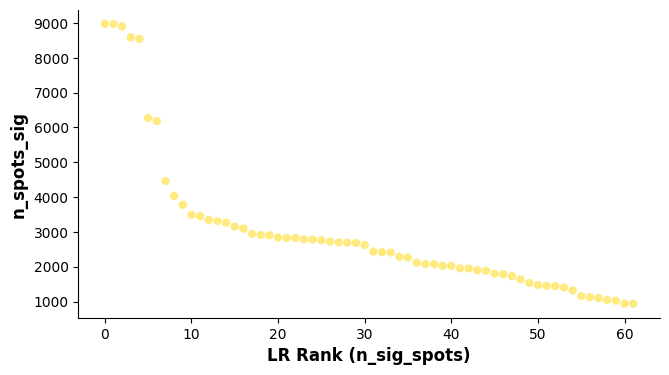

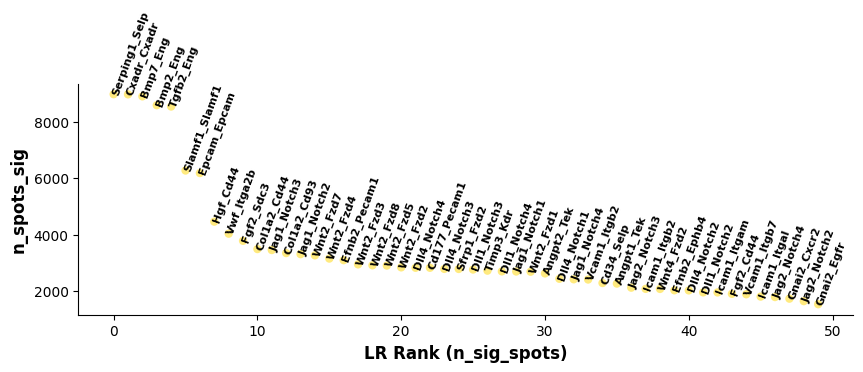

In [14]:
# Showing the rankings of the LR from a global and local perspective.
# Ranking based on number of significant hotspots.
st.pl.lr_summary(adata, n_top=500)
st.pl.lr_summary(adata, n_top=50, figsize=(10,3))

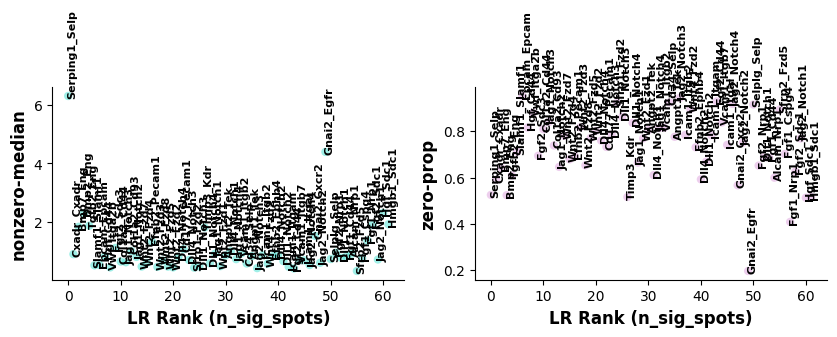

In [15]:
st.pl.lr_diagnostics(adata, figsize=(10,2.5))


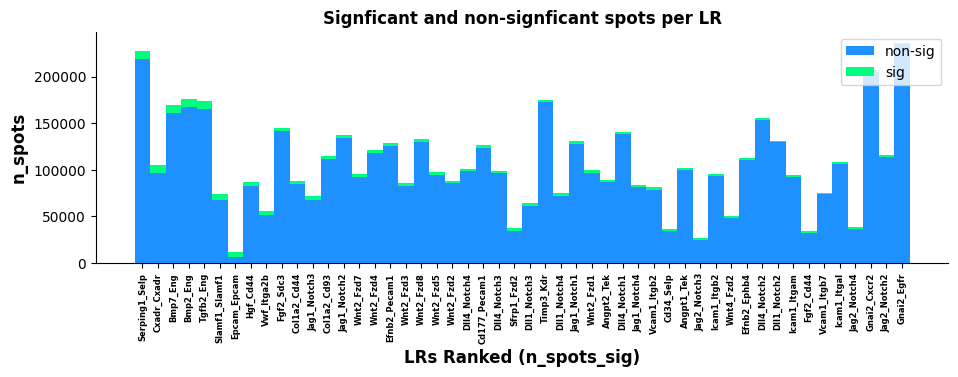

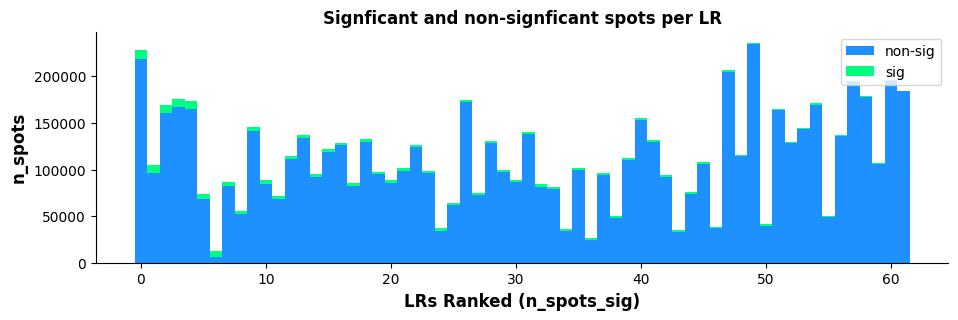

In [16]:
st.pl.lr_n_spots(adata, n_top=50, figsize=(11, 3),
                    max_text=100)
st.pl.lr_n_spots(adata, n_top=500, figsize=(11, 3),
                    max_text=100)

In [17]:
best_lr = adata.uns['lr_summary'].index.values[0] # Just choosing one of the top from lr_summary


In [18]:
'''
stats = ['lr_scores', 'p_vals', 'p_adjs', '-log10(p_adjs)']
fig, axes = plt.subplots(ncols=len(stats), figsize=(16,6))
for i, stat in enumerate(stats):
    st.pl.lr_result_plot(adata, use_result=stat, use_lr=best_lr, show_color_bar=False, ax=axes[i])
    axes[i].set_title(f'{best_lr} {stat}')
'''

"\nstats = ['lr_scores', 'p_vals', 'p_adjs', '-log10(p_adjs)']\nfig, axes = plt.subplots(ncols=len(stats), figsize=(16,6))\nfor i, stat in enumerate(stats):\n    st.pl.lr_result_plot(adata, use_result=stat, use_lr=best_lr, show_color_bar=False, ax=axes[i])\n    axes[i].set_title(f'{best_lr} {stat}')\n"

# Predicting significant CCIs


In [ ]:
# Running the counting of co-occurence of cell types and LR expression hotspots #
st.tl.cci.run_cci(adata, 'nico_ct', # Spot cell information either in data.obs or data.uns
                  min_spots=3, # Minimum number of spots for LR to be tested.
                  spot_mixtures=True, # If True will use the label transfer scores,
                                      # so spots can have multiple cell types if score>cell_prop_cutoff
                  cell_prop_cutoff=0.2, # Spot considered to have cell type if score>0.2
                  sig_spots=True, # Only consider neighbourhoods of spots which had significant LR scores.
                  n_perms=100 # Permutations of cell information to get background, recommend ~1000
                 )

Falling back to discrete mode.
Getting cached neighbourhood information...
Getting information for CCI counting...


Counting celltype-celltype interactions per LR and permutating 100 times.:   0%|                                     [ time left: ? ]

In [ ]:
st.pl.cci_check(adata, 'nico_ct')

In [ ]:
# Visualising the no. of interactions between cell types across all LR pairs #
pos_1 = st.pl.ccinet_plot(adata, 'nico_ct', return_pos=True)

# Just examining the cell type interactions between selected pairs #
lrs = adata.uns['lr_summary'].index.values[0:3]
for best_lr in lrs[0:3]:
    st.pl.ccinet_plot(adata, 'cell_type', best_lr, min_counts=2,
                         figsize=(10,7.5), pos=pos_1,
                      )

In [ ]:
st.pl.lr_chord_plot(adata, 'nico_ct')

for lr in lrs:
    st.pl.lr_chord_plot(adata, 'nico_ct', lr)

In [ ]:
# This will automatically select the top interacting CCIs and their respective LRs #
st.pl.lr_cci_map(adata, 'nico_ct', lrs=None, min_total=100, figsize=(20,4))

In [ ]:
st.pl.lr_cci_map(adata, 'nico_ct', lrs=lrs, min_total=100, figsize=(20,4))


In [ ]:
st.pl.cci_map(adata, 'nico_ct')

lrs = adata.uns['lr_summary'].index.values[0:3]
for lr in lrs[0:3]:
    st.pl.cci_map(adata, 'nico_ct', lr)

In [ ]:
adata.write('output_liver_stlearn.h5ad')